<a href="https://colab.research.google.com/github/luckysouthchou/pytorch_udemy/blob/master/MINIST2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip3 install torch torchvision



In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms



In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [0]:
#image = (image - mean) / std
'''If you read the documentation here 872, you will see that both parameters are “Sequences for each channel”. Color images have three channels (red, green, blue), therefore you need three parameters to normalize each channel. The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.'''

transform =  transforms.Compose([transforms.Resize ((28, 28)),
                                #resize it to 28 by 28, because the imgae may be 1000 by 1000 or other scale, we need to make sure and using one standerd
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#training = False .>>> in order to validate the model in the end 

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size =100, shuffle = False)

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  #1, 28, 28 >> 28, 28, 1 (1 is channel) (C, H, W)(channel, height, weight)
  #denormalization
  #print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  #small than0, become 0, bigger than 1, become 1: .clip()
  return image

In [0]:
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

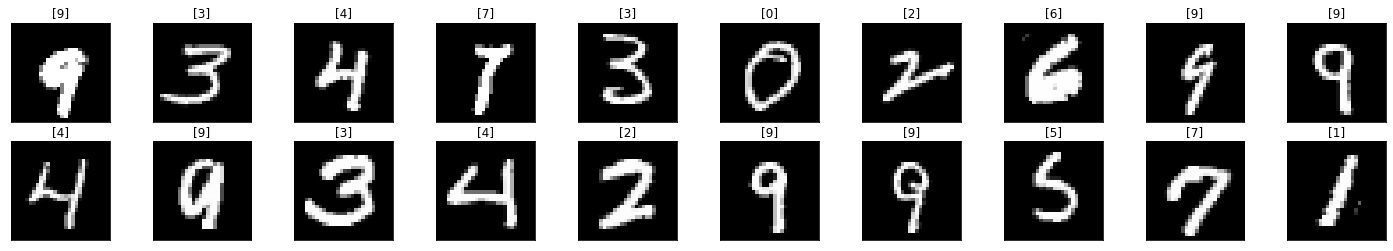

In [38]:
#For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
dataiter  = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize = (25, 4))
#weight, height of the figure(25, 4)
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    #convolutional layer 1: 3 chanel , 20 output chanel , 5 kernel size, stride length 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    #convolutional layer 2: 20 input chanel, 50 output chanel, 5 kernel size/ filter size, stride length 1) 
    self.fc1 = nn.Linear(4*4*50, 500)
    #fully connected layer 1: 28-2*2 = 24, 24/2 = 12, 12-2*2 = 8, 8/2 = 4, 4 by 4 , with 500 chanel 
    self.dropout1 = nn.Dropout(0.5)
    #fully connected layer 2: 
    self.fc2 = nn.Linear(500, 10)
    
  def forward(self, x):
    #define convolution forward and  pooling layer
    x = F.relu(self.conv1(x))
    #relu:activation function to transfer value to probability
    #define convolution layer
    x = F.max_pool2d(x, 2, 2)
    #mdefine pooling layer: ax pooling kernel , 2 by 2 kernel 
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    #reshape x into falttened 
    x = F.relu(self.fc1(x))
    #relu is used to transfer value to probability
    x = self.dropout1(x)
    x = self.fc2(x)
    return x



In [40]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#we can reset the learning rates to 0.001 even 0.0001to have a good prediction

In [0]:
epochs = 15
running_loss_history = []
#store loss of every epoch
running_correct_history = []
#accuracy of every epoch
val_running_loss_history = []
val_running_correct_history = []
#store validation loss , and validation loss correction to a empty array
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  #inistiate accuract value = 0.00
  val_running_loss = 0.0
  val_running_correct = 0.0


  for inputs, labels in training_loader: 
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    #1, 784(1 channel, 28 * 28), make image 1 dimentional  
    outputs = model(inputs)
    #model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    #return the index of the maximum probability value for that image
    running_corrects += torch.sum(preds == labels.data)

    running_loss += loss.item()
    #running loss: loss plus per batch

  else:
    #validation!
    with torch.no_grad():
      #set all grad flags to be false to save the memory

      for val_inputs, val_labels  in validation_loader:
      #validation process
        #val_inputs = val_inputs.view(inputs.shape[0], -1)
        #1, 784(1 channel, 28 * 28), make image 1 dimentional  
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        #model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
        val_loss = criterion(val_outputs, val_labels)
        #do not need to pred and zero_grad() and backward and step, because it's validation step. it has their own labels correctly
        
        
        _, val_preds = torch.max(val_outputs, 1)
        #return the index of the maximum probability value for that image
        val_running_correct += torch.sum(val_preds == val_labels.data)

        val_running_loss += val_loss.item()
        #running loss: loss plus per batch



    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    #epoch_loss : loss of every epoch
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)


    #validation 
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_correct.float()/len(validation_loader)

    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_acc)
    print('epoch:',(e+1))










    
    #print test datse set out comes with loss and accuracy
    print('training loss: {:.4f}'.format(epoch_loss))
    print('trainig accuracy: {:.4f}'.format(epoch_acc.item()))
    #print validation 
    print('val_training loss: {:.4f}'.format(val_epoch_loss))
    print('val_trainig accuracy: {:.4f}'.format(val_epoch_acc.item()))

epoch: 1
training loss: 0.5876
trainig accuracy: 83.7217
val_training loss: 0.1943
val_trainig accuracy: 94.2100
epoch: 2
training loss: 0.1554
trainig accuracy: 95.4233
val_training loss: 0.1080
val_trainig accuracy: 96.7900
epoch: 3
training loss: 0.1046
trainig accuracy: 96.8583
val_training loss: 0.0824
val_trainig accuracy: 97.5300
epoch: 4
training loss: 0.0811
trainig accuracy: 97.6117
val_training loss: 0.0637
val_trainig accuracy: 98.1400
epoch: 5
training loss: 0.0681
trainig accuracy: 97.9450
val_training loss: 0.0556
val_trainig accuracy: 98.2300


In [0]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

In [0]:
#to see is the plot of accuracy has convergency 

In [0]:
#this graph is fluctuated, so reset the learning rates to a more minor vakue 0.01>>>> 0.001>>>>>0.0001, and run the program again

In [0]:
plt.plot(running_correct_history, label = 'training accuracy')
plt.plot(val_running_correct_history, label = 'validation training accuracy')
plt.legend()

In [0]:
!pip3 install pillow==7.0.0

import PIL.ImageOps

In [0]:
import requests

from PIL import Image
#PIL:python image library
#using a image from internet
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

In [0]:
img = PIL.ImageOps.invert(img)
#change background color form white to black because our test data is black background, we need to confirm that
img = img.convert('1')
#trasnform ima from 1000 by 1000 to 28 by 28
img = transform(img)
#make sure to resieze image to 28 by 28 and from numpy array to tensor format
plt.imshow(im_convert(img))

In [0]:
images = img.to(device)
#print(img[0].size())
image = images[0].unsqueeze(0).unsqueeze(0)
#unsqueeze(0) add x axis bracket to orginal tensor, unqueeze(1) add y axis bracket to original tensor in order to create 3 dimential chanel
#1, 784(1 channel, 28 * 28), make image 1 dimentional  
output = model(image)
#model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
_, pred = torch.max(output, 1)
#return the index of the maximum probability value for that image
print(pred.item())

In [0]:
#For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
dataiter  = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))

#weight, height of the figure(25, 4)
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{}({})'.format(str(preds[idx].item()), str(labels[idx].item())), color=('green' if preds[idx]==labels[idx] else 'red'))
